### Preprocessing

In [1]:
# imports and constants
import pyloudnorm as pyln
import librosa
from IPython.display import Audio
import pyloudnorm as pyln
import pickle
import numpy as np
import os
import random
import gc
from pprint import pprint
import numpy


# constants
DATA_PATHS_EMOTIONS = r'C:\Users\miche\spyder_10jan2024\folders_samples_spec_ecc\guitar_emotion_info\listening-test-results/listen_audio_paths_emotions.pickle'
files_each_emotion = [96, 116, 77, 98]   # ['aggressive', 'relaxed', 'happy', 'sad']
SAMPLING_RATE = 22050
SEGMENT_LENGTH = SAMPLING_RATE * 3  # 66150
EMOTIONS = ['aggressive', 'relaxed', 'happy', 'sad']


# functions
def normalize_loudness(audio_file, sr, loudness_level=-26, verbose=False):
    # create BS.1770 meter and get audio loudness
    meter = pyln.Meter(sr)
    loudness = meter.integrated_loudness(audio_file)
    # loudness normalize to -26 dB LUFS
    loudness_normalized_audio = pyln.normalize.loudness(audio_file, loudness, loudness_level)
    if verbose:
        print(f"\nDETAILS OF normalized_audio FUNCTION\n"
              f"- old loudness: {loudness}\n"
              f"- new loudness: {meter.integrated_loudness(loudness_normalized_audio)}")
    return loudness_normalized_audio

In [2]:
with open(DATA_PATHS_EMOTIONS, 'rb') as f:
    data = pickle.load(f)

In [3]:
import os

def update_path(old_path, new_base_path):

    # get subpath strating from 'guitar_emotions'
    parts = old_path.replace('\\','/').split('guitar_emotions', 1)
    if len(parts) != 2:
        raise ValueError(f"'guitar_emotions' not found in path: {old_path}")

    sub_path = parts[1].lstrip('/\\')
    # build new path
    new_path = os.path.join(new_base_path, 'guitar_emotions', sub_path)
    return new_path
        

old = r'C:/Users/miche/Desktop/guitar_emotions\\aggressive\\name_audio_file.wav'
new_base = r'C:\Users\miche\spyder_10jan2024\folders_samples_spec_ecc'

update_path(old, new_base)

# get x and y converting the path to the new folder
X = []
y = []
for file_path, emotion in zip(data['audio_path'], data['emotion']):

    updated_path = update_path(file_path, new_base)
    X.append(updated_path)
    y.append(emotion) 


In [4]:
# make train test split
from sklearn.model_selection import GroupShuffleSplit, StratifiedGroupKFold
import os

# estrai nome del musicista dal path
def extracet_musician_name(path):
    filename = os.path.basename(path)
    parts  = filename.split('_')
    return parts[-3] if len(parts) >= 3 else 'unknown'

# lista con nome del musicista per ogni file
groups = [extracet_musician_name(p) for p in X]


# OLD
#splitter = GroupShuffleSplit(test_size=0.2, n_splits=1, random_state=42)
#train_idx, test_idx = next(splitter.split(X, y, groups=groups))

# NEW
splitter = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=1)
train_idx, test_idx = next(splitter.split(X, y, groups=groups))


# creare i set
X_train = [X[i] for i in train_idx]
y_train = [y[i] for i in train_idx]
X_test = [X[i] for i in test_idx]
y_test = [y[i] for i in test_idx]


# verifica che sia stato diviso correttamente - niente sovrapposizioni
train_musicians = set(extracet_musician_name(X[i]) for i in train_idx)
test_musicians = set(extracet_musician_name(X[i]) for i in test_idx)
overlap = train_musicians & test_musicians

print('train_set:', train_musicians, end='\n\n')
print('test_set:', test_musicians, end='\n\n')
print('overlap:', overlap)


train_set: {'TizBol', 'NicLat', 'AntDel', 'AngLoi', 'TomCan', 'MasChi', 'SteRom', 'palm', 'FilMel', 'DavRos', 'GioAcq', 'OweWin', 'AdoLaV', 'AntPao', 'CesSam', 'GiaFer', 'SamLor', 'LucFra', 'TizCam', 'AleMar', 'LucTur', 'pick', 'FedCer', 'FraBen', 'SimArm', 'MarPia'}

test_set: {'NicCon', 'GioDic', 'SalOli', 'MatRig', 'DavBen', 'ValFui'}

overlap: set()


In [5]:
import librosa
import numpy as np
import os
import pickle

import matplotlib.pyplot as plt
import librosa.display

# Constants
SAMPLING_RATE = 22050
SEGMENT_DURATION = 3  # seconds
SEGMENT_SAMPLES = SEGMENT_DURATION * SAMPLING_RATE
N_MELS = 128
N_FFT = 2048
HOP_LENGTH = 512
SAVE = True


OVERLAP = 0.75
HOP_LENGTH_SEGM = int(SEGMENT_SAMPLES * (1 - OVERLAP))
print(HOP_LENGTH_SEGM/22050)


def process_audio_file(file_path, label, data_dict):
    
    try:

        y, sr = librosa.load(file_path, sr=SAMPLING_RATE)
        #num_segments = len(y) // SEGMENT_SAMPLES
        max_start = len(y) - SEGMENT_SAMPLES
        num_segments = max_start // HOP_LENGTH_SEGM + 1

        for i in range(num_segments):
            #start = i * SEGMENT_SAMPLES
            start = i * HOP_LENGTH_SEGM
            end = start + SEGMENT_SAMPLES
            segment = y[start:end]

            # get mel spec
            mel = librosa.feature.melspectrogram(y=segment, sr=SAMPLING_RATE, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS)

            mel_db = librosa.power_to_db(mel, ref=np.max)  

            # normalize, set to 0 if signal is zero o near
            if abs( mel_db.max() - mel_db.min() ) < 1e-6:
                mel_db_norm = np.zeros_like(mel_db)
                print("spectrogram set to zero")
            else:
                mel_db_norm = ( mel_db - mel_db.min() ) / ( mel_db.max() - mel_db.min() )

            
            data_dict['spec'].append(mel_db_norm)
            data_dict['label'].append(label)
            data_dict['segment_index'].append(i)
            data_dict['original_path'].append(file_path)

    except Exception as e:
        print(f'error processing {file_path}: {e}')


# --- doing the preprocessing ---

train_data_dict = { 'spec': [], 'label': [], 'segment_index': [], 'original_path': [] }
test_data_dict = { 'spec': [], 'label': [], 'segment_index': [], 'original_path': [] }

for path, label in zip(X_train, y_train):
    process_audio_file(path, label, train_data_dict)

for path, label in zip(X_test, y_test):
    process_audio_file(path, label, test_data_dict)

# save audio files
TRAIN_SPEC_PATH = 'C:\\Users\\miche\\spyder_10jan2024\\folders_samples_spec_ecc\\1__app_emotions\\train_data_dict_XXoverlap.pkl'
TEST_SPEC_PATH = 'C:\\Users\\miche\\spyder_10jan2024\\folders_samples_spec_ecc\\1__app_emotions\\test_data_dict_XXoverlap.pkl'

if SAVE:
    with open(TRAIN_SPEC_PATH, 'wb') as f:
        pickle.dump(train_data_dict, f)
    with open(TEST_SPEC_PATH, 'wb') as f:
        pickle.dump(test_data_dict, f)

print(f"saved {len(train_data_dict['spec'])} segments to {TRAIN_SPEC_PATH}")
print(f"saved {len(test_data_dict['spec'])} segments to {TEST_SPEC_PATH}")

 
#not overlap -> train: 2742 segments, test 674 segments
#75% overlap -> train: 10544 segments, test 2562 segments
#87.5% overlap -> train: 20933 segments, test 5081 segments

0.3749659863945578
spectrogram set to zero
spectrogram set to zero
spectrogram set to zero
saved 20933 segments to C:\Users\miche\spyder_10jan2024\folders_samples_spec_ecc\1__app_emotions\train_data_dict_875overlap.pkl
saved 5081 segments to C:\Users\miche\spyder_10jan2024\folders_samples_spec_ecc\1__app_emotions\test_data_dict_875overlap.pkl


### Classification

In [1]:

# maybe we can delete some of these imports
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
import gc


import librosa
import os
import keras
from keras.applications import inception_v3
#from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pickle
from keras.utils import load_img, img_to_array



# build and train a CNN
def build_model(input_shape, learning_rate=0.001, classes=4, filters=[16, 16, 16, 16], neurons=32, function='softmax'):
    # create model
    model = keras.Sequential()
    # 1st conv layer
    model.add(keras.layers.Conv2D(filters[0], (3, 3), name='conv_1', activation='relu', input_shape=input_shape, padding='same'))
    model.add(keras.layers.MaxPool2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())
    # 2nd conv layer
    model.add(keras.layers.Conv2D(filters[1], (3, 3), name='conv_2', activation='relu', padding='same'))
    model.add(keras.layers.MaxPool2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())
    # 3rd conv layer
    model.add(keras.layers.Conv2D(filters[2], (3, 3), name='conv_3', activation='relu', padding='same'))
    model.add(keras.layers.MaxPool2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())
    # 4th conv layer
    model.add(keras.layers.Conv2D(filters[3], (3, 3), name='conv_4', activation='relu', padding='same'))
    model.add(keras.layers.MaxPool2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # flatten the output and feed into dense layer
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(neurons, name='dense_1', activation='relu'))
    model.add(keras.layers.Dropout(0.2))
    
    # output layer   
    model.add(keras.layers.Dense(classes, activation=function))
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=["accuracy"])
    
    return model



# with early stopping
def train(model_, X_train, y_train, X_test, y_test, epochs, batch_size, patience=5):

    # for early stopping
    count = 0
    best_test_accuracy = 0
    
    train_accuracies = []
    test_accuracies = []
    
    train_losses = []
    test_losses = []

    for epoch in range(epochs):
        print('epoch:', epoch+1)
        model_.fit(X_train, y_train, epochs=1, batch_size=batch_size, shuffle=True)

        train_loss, train_accuracy =  model_.evaluate(X_train, y_train, verbose=0)
        train_accuracies.append(train_accuracy)
        train_losses.append(train_loss)

        test_loss, test_accuracy =  model_.evaluate(X_test, y_test, verbose=0)
        test_accuracies.append(test_accuracy)
        test_losses.append(test_loss)
        
        print(f'- train acc: {train_accuracy},  - test acc: {test_accuracy}')   

        
        if test_accuracy < best_test_accuracy:            
            count+=1

            print(f'No improvement ({count}/{patience})')
            if count >= patience: 
                print('Early stopping triggered')
                break

        else:
            best_test_accuracy = test_accuracy
            count=0
        
        #tf.keras.backend.clear_session()
        gc.collect()

    return train_accuracies, train_losses, test_accuracies, test_losses



# GPT vesrion with some improvements: such as putting the weight of the best model --------- test and re-write
import gc
import numpy as np

def train(model_, X_train, y_train, X_test, y_test, epochs, batch_size, patience=5):
    count = 0
    best_test_accuracy = 0.0
    best_weights = None

    train_accuracies, test_accuracies = [], []
    train_losses, test_losses = [], []

    for epoch in range(epochs):
        print(f'Epoch {epoch+1}/{epochs}')
        model_.fit(X_train, y_train, epochs=1, batch_size=batch_size, shuffle=True, verbose=1)

        train_loss, train_accuracy = model_.evaluate(X_train, y_train, verbose=0)
        test_loss, test_accuracy = model_.evaluate(X_test, y_test, verbose=0)

        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)
        train_losses.append(train_loss)
        test_losses.append(test_loss)

        print(f'- train acc: {train_accuracy:.4f}, test acc: {test_accuracy:.4f}')

        if test_accuracy <= best_test_accuracy:
            count += 1
            print(f'No improvement ({count}/{patience})')
            if count >= patience:
                print('Early stopping triggered.')
                if best_weights:
                    model_.set_weights(best_weights)  # Restore best weights
                break
        else:
            best_test_accuracy = test_accuracy
            best_weights = model_.get_weights()
            count = 0

        gc.collect()

    return train_accuracies, train_losses, test_accuracies, test_losses
# -------------------------------------------------------------------------------------------------------------------


def plot_acc_loss(train_acc, train_loss, test_acc, test_loss, Print=False, save_path=False):
    fig, axs = plt.subplots(2)
    # create accuracy sublpot
    axs[0].plot(train_acc, label="train accuracy")
    axs[0].plot(test_acc, label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    #axs[0].set_title("Accuracy eval")
    axs[0].set_xticks(np.arange(0, len(train_acc)), np.arange(1, len(train_acc)+1))

    # create error sublpot
    axs[1].plot(train_loss, label="train error")
    axs[1].plot(test_loss, label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    #axs[1].set_title("Error eval")
    axs[1].set_xticks(np.arange(0, len(train_acc)), np.arange(1, len(train_acc)+1))



C:\Users\miche\anaconda3\envs\py310\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [11]:
gc.collect()

#TRAIN_SPEC_PATH = 'C:\\Users\\miche\\spyder_10jan2024\\folders_samples_spec_ecc\\1__app_emotions\\train_data_dict.pkl'
#TEST_SPEC_PATH = 'C:\\Users\\miche\\spyder_10jan2024\\folders_samples_spec_ecc\\1__app_emotions\\test_data_dict.pkl'

TRAIN_SPEC_PATH = 'C:\\Users\\miche\\spyder_10jan2024\\folders_samples_spec_ecc\\1__app_emotions\\train_data_dict_50overlap.pkl'
TEST_SPEC_PATH = 'C:\\Users\\miche\\spyder_10jan2024\\folders_samples_spec_ecc\\1__app_emotions\\test_data_dict_50overlap.pkl'

#TRAIN_SPEC_PATH = 'C:\\Users\\miche\\spyder_10jan2024\\folders_samples_spec_ecc\\1__app_emotions\\train_data_dict_75overlap.pkl'
#TEST_SPEC_PATH = 'C:\\Users\\miche\\spyder_10jan2024\\folders_samples_spec_ecc\\1__app_emotions\\test_data_dict_75overlap.pkl'

##TRAIN_SPEC_PATH = 'C:\\Users\\miche\\spyder_10jan2024\\folders_samples_spec_ecc\\1__app_emotions\\train_data_dict_875overlap.pkl'
##TEST_SPEC_PATH = 'C:\\Users\\miche\\spyder_10jan2024\\folders_samples_spec_ecc\\1__app_emotions\\test_data_dict_875overlap.pkl'

# forse per il test dovrei usare sempre quella senza ovelap? i chitarristi in teoria sono gli stessi nel test set

with open(TRAIN_SPEC_PATH, 'rb') as f:
    data_train = pickle.load(f)

with open(TEST_SPEC_PATH, 'rb') as f:
    data_test = pickle.load(f)

In [6]:
# verify if folds has correct number of samples
a = len(data_train['spec']) / 8
print(len(data_train['spec']), end='\n\n' )

for i in range(1, 9):
    print(a * i)

2742

342.75
685.5
1028.25
1371.0
1713.75
2056.5
2399.25
2742.0


In [12]:
from sklearn.model_selection import StratifiedGroupKFold
import numpy as np

# TRAIN
# get data
X = np.array(data_train['spec'])[..., np.newaxis]
y = np.array(data_train['label'])
groups = np.array(data_train['original_path'])

# create split for validation set
sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=0)
for train_idx, val_idx in sgkf.split(X, y, groups):
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]
    break

# add 3 channels
X_train = np.repeat(X_train, 3, axis=-1)
X_val = np.repeat(X_val, 3, axis=-1)


# TEST SET
X_test = np.array(data_test['spec'])[..., np.newaxis]
y_test = np.array(data_test['label'])
X_test = np.repeat(X_test, 3, axis=-1)

# ----------------------------------------------------------------------------------------------

# verify label distribution
print('train distrib', np.bincount(y_train))
print('val distrib', np.bincount(y_val))
print('test distribution', np.bincount(y_test))


train distrib [1006 1428  740 1151]
val distrib [181 314 235 290]
test distribution [285 401 282 336]


In [7]:
# --- # code for scarcity evaluation ---

tf.keras.backend.clear_session()
gc.collect()

from sklearn.model_selection import StratifiedGroupKFold
import numpy as np

# constants
CLASSES = 4
BATCH_SIZE = 32
EPOCHS = 20 # before it was 30
FILTERS = [8, 8, 16, 16]
NEURONS = 32
LEARNING_RATE = 0.0001

# TEST SET
X_test = np.array(data_test['spec'])[..., np.newaxis]
y_test = np.array(data_test['label'])
X_test = np.repeat(X_test, 3, axis=-1)

# TRAIN SET
X = np.array(data_train['spec'])[..., np.newaxis]
y = np.array(data_train['label'])
groups = np.array(data_train['original_path'])


# Create 8 folds
#n_folds = 8
#sgkf = StratifiedGroupKFold(n_splits=n_folds, shuffle=True, random_state=0)
#splits = list(sgkf.split(X, y, groups))
# m. splits is a list of 8 tuples: [ ( train_idx, valid_idx ), ... ]  each contains the indeces 
# for the train and the test: splits[][0], splits[][1] in my case we use only the validation which has 1 fold



n_folds = 8
n_runs = 12
all_accuracies = []

for run in range(n_runs):

    print(f'\n--- Run {run + 1}/{n_runs} ---\n')
    sgkf = StratifiedGroupKFold(n_splits=n_folds, shuffle=True, random_state=run)  # vary seed
    splits = list(sgkf.split(X, y, groups))



    run_accuracies = []
    
    for num_folds in range(1, n_folds + 1):
        selected_indices = np.concatenate( [splits[i][1] for i in range(num_folds)] )  # splits[i][1] are the valid sets (1/8 of the data)
    
        X_train = X[selected_indices]
        y_train = y[selected_indices]    
        X_train = np.repeat(X_train, 3, axis=-1)
    
        # print some information on the current set, maybe number of samples, or some example of indices
        print(f'training with {num_folds} fold(s) - training set size: {len(X_train)}')
    
        # real training part
        tf.keras.backend.clear_session()
        gc.collect()
        model = build_model(input_shape =  X_test.shape[1:], learning_rate=LEARNING_RATE, classes=CLASSES, filters=FILTERS, neurons=NEURONS)
        history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, shuffle=True)
        
        # Evaluate on test set
        accuracy = model.evaluate(X_test, y_test, verbose=0)[1]
        print(f'Folds: {num_folds} - accuracy: {accuracy:.4f}\n')
        run_accuracies.append(accuracy)
    

    all_accuracies.append(run_accuracies)

# -----------------------------




--- Run 1/12 ---

training with 1 fold(s) - training set size: 653
Epoch 1/20
21/21 [==============================] - 1s 12ms/step - loss: 1.6831 - accuracy: 0.3538
Epoch 2/20
21/21 [==============================] - 0s 10ms/step - loss: 1.3396 - accuracy: 0.4349
Epoch 3/20
21/21 [==============================] - 0s 10ms/step - loss: 1.2329 - accuracy: 0.4594
Epoch 4/20
21/21 [==============================] - 0s 10ms/step - loss: 1.1294 - accuracy: 0.5115
Epoch 5/20
21/21 [==============================] - 0s 10ms/step - loss: 1.0354 - accuracy: 0.5743
Epoch 6/20
21/21 [==============================] - 0s 10ms/step - loss: 1.0407 - accuracy: 0.5727
Epoch 7/20
21/21 [==============================] - 0s 10ms/step - loss: 0.9497 - accuracy: 0.6371
Epoch 8/20
21/21 [==============================] - 0s 9ms/step - loss: 0.8945 - accuracy: 0.6355
Epoch 9/20
21/21 [==============================] - 0s 10ms/step - loss: 0.8874 - accuracy: 0.6248
Epoch 10/20
21/21 [=======================

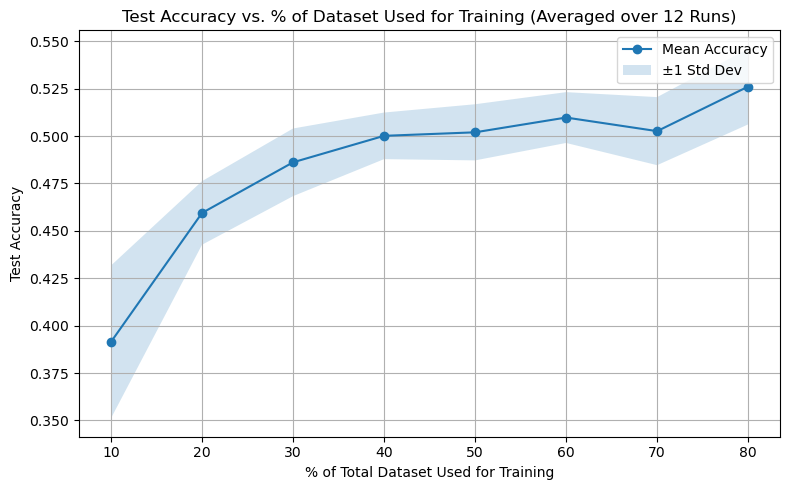

In [8]:
all_accuracies = np.array(all_accuracies)
mean_accuracies = all_accuracies.mean(axis=0)
std_accuracies = all_accuracies.std(axis=0)

x_percent = [10 * i for i in range(1, n_folds + 1)]


# Plot
plt.figure(figsize=(8, 5))
plt.plot(x_percent, mean_accuracies, marker='o', label='Mean Accuracy')
plt.fill_between(x_percent,
                 mean_accuracies - std_accuracies,
                 mean_accuracies + std_accuracies,
                 alpha=0.2, label='±1 Std Dev')
plt.title(f'Test Accuracy vs. % of Dataset Used for Training (Averaged over {n_runs} Runs)')
plt.xlabel('% of Total Dataset Used for Training')
plt.ylabel('Test Accuracy')
plt.xticks(x_percent)
plt.grid(True)
plt.legend()
plt.tight_layout()


plt.savefig("train50over_test0over_20epochs.png", dpi=300)

plt.show()

In [9]:
!pip install keras-tuner

   ---------------------------------------- 0.0/129.1 kB ? eta -:--:--
   ---------------------------------------- 0.0/129.1 kB ? eta -:--:--
   ---------------------------------------- 0.0/129.1 kB ? eta -:--:--
   --- ------------------------------------ 10.2/129.1 kB ? eta -:--:--
   --------- ----------------------------- 30.7/129.1 kB 325.1 kB/s eta 0:00:01
   --------- ----------------------------- 30.7/129.1 kB 325.1 kB/s eta 0:00:01
   ------------------ -------------------- 61.4/129.1 kB 326.1 kB/s eta 0:00:01
   ------------------------------ ------- 102.4/129.1 kB 420.8 kB/s eta 0:00:01
   -------------------------------------- 129.1/129.1 kB 447.0 kB/s eta 0:00:00


In [10]:
X_train[0].shape

(128, 130, 3)

In [20]:
from tensorflow import keras
from keras_tuner import HyperParameters
from keras_tuner.tuners import RandomSearch

# hyperparamtere tuning with keras-tuner
# gpt code
def build_model(hp):
    input_shape = (128, 130, 3)  # adjust as needed
    classes = 4

    model = keras.Sequential()

    # Convolutional layers
    for i in range(4):
        filters = hp.Int(f'filters_{i+1}', min_value=8, max_value=32, step=8)
        if i == 0:
            model.add(keras.layers.Conv2D(filters, (3, 3), activation='relu',
                                          input_shape=input_shape, padding='same', name=f'conv_{i+1}'))
        else:
            model.add(keras.layers.Conv2D(filters, (3, 3), activation='relu',
                                          padding='same', name=f'conv_{i+1}'))
        model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
        model.add(keras.layers.BatchNormalization())

    model.add(keras.layers.Flatten())

    # Dense layer
    neurons = hp.Int('dense_neurons', min_value=32, max_value=128, step=32)
    model.add(keras.layers.Dense(neurons, activation='relu'))
    
    # Dropout (optional)
    dropout_rate = hp.Float('dropout_rate', 0.1, 0.5, step=0.1)
    model.add(keras.layers.Dropout(dropout_rate))

    # Output layer
    model.add(keras.layers.Dense(classes, activation='softmax'))

    # Learning rate
    learning_rate = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4, 1e-5])
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model


tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=30,
    executions_per_trial=5,
    directory='my_dir',
    project_name='cnn_tuning'
)



tuner.search(
    X_train, y_train,
    epochs=15,  # fixed
    batch_size=32,  # or try hp.Choice if you want to tune
    validation_data=(X_val, y_val)
)


Trial 30 Complete [00h 04m 26s]
val_accuracy: 0.47215685844421384

Best val_accuracy So Far: 0.513725483417511
Total elapsed time: 02h 49m 01s


In [14]:
best_model = tuner.get_best_models(1)[0]
best_hps = tuner.get_best_hyperparameters(1)[0]


In [15]:
best_model.evaluate(X_test, y_test)

41/41 [==============================] - 2s 17ms/step - loss: 1.3005 - accuracy: 0.4992


[1.3004858493804932, 0.4992331266403198]

In [21]:
import os


# Create output folder
output_dir = f"keras_tuner_15epochs_trial30_exec5"
os.makedirs(output_dir, exist_ok=True)

# Get top 3 models and their hyperparameters
best_models = tuner.get_best_models(num_models=3)
best_hps = tuner.get_best_hyperparameters(num_trials=3)

for i, model in enumerate(best_models):
    # Evaluate the model
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    
    # Format accuracy
    acc_percent = round(accuracy * 100, 2)
    
    # Print performance
    print(f"Model {i+1} Accuracy on Test Set: {acc_percent:.2f}%")
    
    # File paths
    model_path = f"{output_dir}/best_model_{i+1}_acc_{acc_percent:.2f}.h5"
    hparams_path = f"{output_dir}/best_model_{i+1}_acc_{acc_percent:.2f}_hparams.txt"
    
    # Save model
    model.save(model_path)
    
    # Save hyperparameters
    with open(hparams_path, 'w') as f:
        f.write(str(best_hps[i].values))



Model 1 Accuracy on Test Set: 53.14%
Model 2 Accuracy on Test Set: 49.92%
Model 3 Accuracy on Test Set: 52.07%


In [3]:
'''
# constants
BATCH_SIZE = 32
EPOCHS = 20
CLASSES = 4
FILTERS = [8, 8, 16, 16]
#FILTERS = [16, 16, 16, 16]
NEURONS = 32
LEARNING_RATE = 0.0001

tf.keras.backend.clear_session()
gc.collect()

model = build_model(input_shape =  X_test.shape[1:], learning_rate=LEARNING_RATE, classes=CLASSES, filters=FILTERS, neurons=NEURONS)
model.summary()

# train the model
train_accuracies, train_losses, test_accuracies, test_losses = train(model, X_train, y_train, X_val, y_val, epochs=EPOCHS, batch_size=BATCH_SIZE, patience=3)

# plot accuracy and loss
plot_acc_loss(train_accuracies, train_losses, test_accuracies, test_losses, Print=False, save_path=False)
'''

'\n# constants\nBATCH_SIZE = 32\nEPOCHS = 20\nCLASSES = 4\nFILTERS = [8, 8, 16, 16]\n#FILTERS = [16, 16, 16, 16]\nNEURONS = 32\nLEARNING_RATE = 0.0001\n\ntf.keras.backend.clear_session()\ngc.collect()\n\nmodel = build_model(input_shape =  X_test.shape[1:], learning_rate=LEARNING_RATE, classes=CLASSES, filters=FILTERS, neurons=NEURONS)\nmodel.summary()\n\n# train the model\ntrain_accuracies, train_losses, test_accuracies, test_losses = train(model, X_train, y_train, X_val, y_val, epochs=EPOCHS, batch_size=BATCH_SIZE, patience=3)\n\n# plot accuracy and loss\nplot_acc_loss(train_accuracies, train_losses, test_accuracies, test_losses, Print=False, save_path=False)\n'

In [27]:
# use a more conventional way of training

tf.keras.backend.clear_session()
gc.collect()


# constants
CLASSES = 4

BATCH_SIZE = 32
EPOCHS = 30
FILTERS = [8, 8, 16, 16]
NEURONS = 32
LEARNING_RATE = 0.0001

PATIENCE = 10

tf.keras.backend.clear_session()
gc.collect()

model = build_model(input_shape =  X_test.shape[1:], learning_rate=LEARNING_RATE, classes=CLASSES, filters=FILTERS, neurons=NEURONS)
model.summary()

from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=PATIENCE,
    restore_best_weights=True,
    verbose=2
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=True,
    callbacks=[early_stopping]
)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (None, 128, 130, 8)       224       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 65, 8)        0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 64, 65, 8)        32        
 ormalization)                                                   
                                                                 
 conv_2 (Conv2D)             (None, 64, 65, 8)         584       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 33, 8)        0         
 2D)                                                             
                                                        

In [28]:
model.evaluate(X_test, y_test)

81/81 [==============================] - 2s 19ms/step - loss: 0.9855 - accuracy: 0.5101


[0.985493004322052, 0.5101483464241028]

In [29]:
SAVE_MODEL_PATH = r'C:\Users\miche\spyder_10jan2024\folders_samples_spec_ecc\1__app_emotions\models\model_75_over_51_histograms_sigmoid.h5'
model.save(SAVE_MODEL_PATH)


### prediction on different segments of an entire guitar execution

In [8]:
# imports and constants
import pyloudnorm as pyln
import librosa
from IPython.display import Audio
import pyloudnorm as pyln
import pickle
import numpy as np
import os
import random
import gc
from pprint import pprint
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

Playing segment 0 


1/1 [==============================] - 0s 391ms/step
Playing segment 1 


1/1 [==============================] - 0s 86ms/step
Playing segment 2 


1/1 [==============================] - 0s 80ms/step
Playing segment 3 


1/1 [==============================] - 0s 68ms/step
Playing segment 4 


1/1 [==============================] - 0s 50ms/step
final prediction: happy, true label: happy


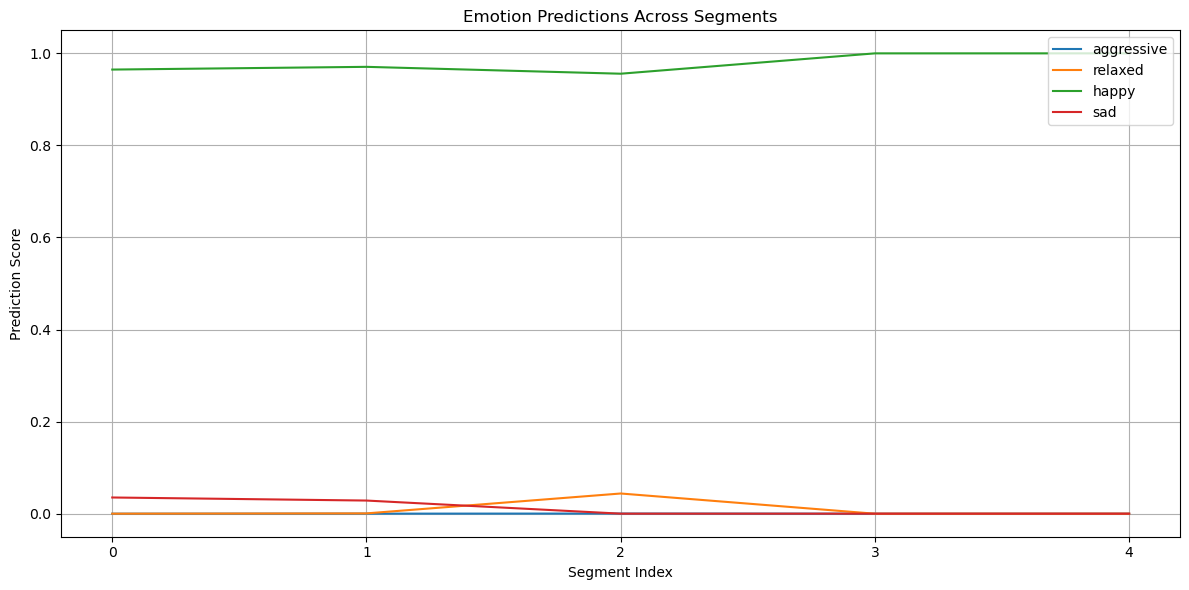

In [22]:

# load test set to get the original path
TEST_SPEC_PATH = 'C:\\Users\\miche\\spyder_10jan2024\\folders_samples_spec_ecc\\1__app_emotions\\test_data_dict.pkl'
SAVE_MODEL_PATH = r'C:\Users\miche\jupyter_08jan24\7__XAI_emotion_project\keras_tuner_15epochs_trial30_exec5\best_model_1_acc_53.14.h5'


# try 75% overlap
#TEST_SPEC_PATH = 'C:\\Users\\miche\\spyder_10jan2024\\folders_samples_spec_ecc\\1__app_emotions\\train_data_dict_75overlap.pkl'
#SAVE_MODEL_PATH = r'C:\Users\miche\spyder_10jan2024\folders_samples_spec_ecc\1__app_emotions\models\model_acc54_75overlap.h5'

EMOTIONS = ['aggressive', 'relaxed', 'happy', 'sad']

SAMPLING_RATE = 22050
SEGMENT_DURATION = 3  # seconds
SEGMENT_SAMPLES = SEGMENT_DURATION * SAMPLING_RATE
N_MELS = 128
N_FFT = 2048
HOP_LENGTH = 512

# option 1 - advance of a fraction of the segment
OVERLAP = 0  # 75% overlap
HOP_LENGTH_SEGM = int(SEGMENT_SAMPLES * (1 - OVERLAP))

# option 2 - advance with an arbitrary number of samples
#HOP_LENGTH_SEGM = 1000
#SEGM_DIVISION = SEGMENT_SAMPLES // HOP_LENGTH_SEGM

INDEX = 235

# plot function
def plot_prediction_each_segment(predictions_):
    plt.figure(figsize=(12, 6))
    for emotion in EMOTIONS:
        plt.plot(predictions_['segment_index'], predictions_[emotion], label=emotion)

    plt.xlabel("Segment Index")
    plt.ylabel("Prediction Score")
    plt.title("Emotion Predictions Across Segments")
    plt.legend(loc="upper right")
    plt.grid(True)

    # Set integer ticks on x-axis
    segment_indices = predictions_['segment_index']
    plt.xticks(ticks=range(min(segment_indices), max(segment_indices) + 1))
    plt.tight_layout()
    plt.show()


# get mel log mel spec and normalize
def get_input_sample(segment_):
    mel = librosa.feature.melspectrogram(y=segment_, sr=SAMPLING_RATE, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS)
    mel_db = librosa.power_to_db(mel, ref=np.max)
    mel_db_norm = ( mel_db - mel_db.min() ) / ( mel_db.max() - mel_db.min() )  # normalize 0-1

    # add rgb channels and expand dims
    mel_rgb = np.repeat(mel_db_norm[..., np.newaxis], 3, axis=-1)  # added 3 channels
    return np.expand_dims(mel_rgb, axis=0)


def song_prediction(data_test_, model_, index=100):

    # dictionary to save predictions    
    predictions = { 'aggressive': [], 'relaxed': [], 'happy':  [], 'sad': [], 'segment_index': [] }

    # load audio file
    y, sr = librosa.load(data_test_['original_path'][index], sr=SAMPLING_RATE)
    label = data_test_['label'][index]
    
    
    # num_segments = len(y) // HOP_LENGTH_SEGM - (SEGM_DIVISION-1)  -> my option
    # gpt option
    max_start = len(y) - SEGMENT_SAMPLES
    num_segments = max_start // HOP_LENGTH_SEGM + 1

    list_mel_segments = []  # save preprocessed input sample for each segment
    for i in range(num_segments):

        start = i * HOP_LENGTH_SEGM        
        end = start + SEGMENT_SAMPLES
        segment = y[start:end]                          

        # display each specific segment
        print(f'Playing segment {i} ')
        display(Audio(segment, rate=sr))

        # get spectrogram and prepar
        mel_rgb_batch = get_input_sample(segment)
        list_mel_segments.append(mel_rgb_batch)
        prediction = model_.predict(mel_rgb_batch)[0]          # predict      

        # save information
        for emotion, score in zip(EMOTIONS, prediction):
            predictions[emotion].append(score)
        predictions['segment_index'].append(i)

    # get the overall prediction
    emotion_totals = {emotion: sum(predictions[emotion]) for emotion in EMOTIONS}  # sum segment
    final_prediction = max(emotion_totals, key=emotion_totals.get)                 # get max

    # print and plot
    print(f'final prediction: {final_prediction}, true label: {EMOTIONS[label]}')   
    plot_prediction_each_segment(predictions)

    return list_mel_segments, label


# ideas on an old model -> idea trainare diversi modelli e vedere se ho somiglianze
# 123 - aggressive, easy
# 124 - aggressive, but segment 7 says happy - interesting sample
# 300 - relaxed, not so clear
# 222 - figo qui il modello sbaglia, ma sembra ragionare bene direi, c'è punto solo relax, solo happy, super confusione fra i 4


# load test set - that has the paths saved
with open(TEST_SPEC_PATH, 'rb') as f:
    data_test = pickle.load(f)

# load model
model = load_model(SAVE_MODEL_PATH)

# song prediction for each segment
list_mel_segments, label = song_prediction(data_test, model, INDEX)


In [33]:
# general imports
import os
import keras
from keras.applications import inception_v3
from keras.applications.imagenet_utils import decode_predictions
from skimage.io import imread
import matplotlib.pyplot as plt
import numpy as np
from keras.utils import load_img, img_to_array
import matplotlib.patheffects as path_effects
%matplotlib inline

# lime 
%load_ext autoreload
%autoreload 2
import lime
from lime import lime_image


# functions
# get empirically the bin position of a specific frequency
def get_mel_coeff_from_frequency(freq, sr=22050):    
    duration = 2
    sampling_rate = sr    
    t = np.linspace(0, duration, int(sampling_rate * duration), endpoint=False)  # time samples 
    waveform = 0.5 * np.sin(2 * np.pi * freq * t)   # generate wave     
    mel_spectrogram = librosa.feature.melspectrogram(y=waveform, sr=sr, n_fft=2048, hop_length=512, n_mels=128)  # get mel spec   
    slice = mel_spectrogram[:,30]   # get a slice of the spec    
    return np.argmax(slice)


#(image, n_time_splits=5, low=250, mid_low=1000, mid_high=3000)
def segmentation_meaningful_regions(image, n_time_splits=3, low=250, mid_low=500, mid_high=2000):
    
    low_bin = get_mel_coeff_from_frequency(low)       # 250 -> band 9
    mid_low_bin = get_mel_coeff_from_frequency(mid_low)   # 500 -> band 18
    mid_high_bin = get_mel_coeff_from_frequency(mid_high)  # 2000 -> band 64
    segments = np.zeros(image.shape[:2], dtype=int)   # avoid channel dimension
    
    # find lenghth of each rectangle
    rect_length = image.shape[1] // n_time_splits
    id = 0
    for i in range(n_time_splits):        
        x_start = i * rect_length        
        # assign segment number to the upper rect in this "time" region
        segments[: , x_start : ] = id
        segments[low_bin : , x_start : ] = id + 1
        segments[mid_low_bin :,  x_start : ] = id + 2
        segments[mid_high_bin:,  x_start : ] = id + 3
        id += 4
    return segments 


# si usa? altrimenti cancella
def get_significan_segments(explanation_, fig_path_, num_features_=5):

    COLOR = 'viridis'  # 'magma'
    temp, mask = explanation_.get_image_and_mask(explanation_.top_labels[0], positive_only=True, num_features=num_features_, hide_rest=True)  # set hide_rest=True to see entire image
       
    plt.figure(figsize=(8, 6))
    temp_norm = (temp - temp.min()) / (temp.max() - temp.min())  
    plt.imshow(mark_boundaries(temp_norm, mask), origin='lower', aspect='auto')
    plt.title('Spectrogram')
    plt.xlabel('Time')
    plt.ylabel('Frequency')
    if fig_path_ != False: plt.savefig(fig_path_)    
    plt.show()



def get_heatmap(explanation_, instance_, fig_path_, return_heatmap=False):

    # m. select the class with highest score
    class_index = explanation_.top_labels[0]    
    # map each explanation weight to the corresponding superpixel
    dict_heatmap = dict(explanation_.local_exp[class_index])
    heatmap = np.vectorize(dict_heatmap.get)(explanation_.segments)    
    
    plt.figure(figsize=(8, 6)) 

    image_background = instance_[:,:,0]

    plt.imshow(image_background, aspect='auto', origin='lower', cmap='gray', alpha=1)    
    # plot. use symmetrical colorbar that makes more sense
    plt.imshow(heatmap, aspect='auto', cmap='RdBu', vmin=-heatmap.max(), vmax=heatmap.max(),  origin='lower', alpha=0.8)
    # plt.imshow(heatmap, aspect='auto', cmap='RdBu', vmin=-heatmap.max(), vmax=heatmap.max(), alpha=0.8) #origin='lower' to have (0, 0) left bottom
    
    plt.colorbar()
    plt.title('Spectrogram')
    plt.xlabel('Time')
    plt.ylabel('Frequency')
    if fig_path_ != False: plt.savefig(fig_path_)
    plt.show()
    if return_heatmap: return heatmap


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


1/1 [==============================] - 0s 94ms/step
prediction [[2.6747448e-06 1.8844792e-06 9.9989784e-01 9.7603959e-05]]
pred: happy, true: happy
pred: 2 true: 2


  0%|          | 0/2000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 46ms/step


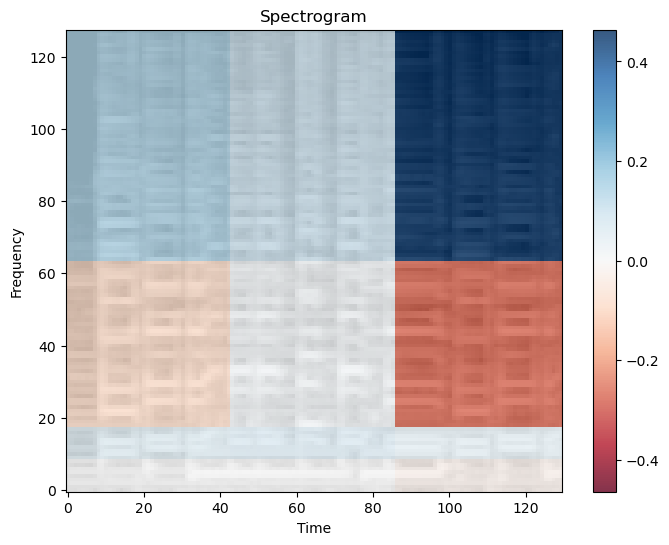

[(11, 0.46369923305519445),
 (10, -0.2674614488316187),
 (3, 0.13932915590321934),
 (7, 0.09560253853508195),
 (2, -0.0842439700986589),
 (5, 0.06251651672905907),
 (1, 0.05785250851228139),
 (9, 0.04589907335168239),
 (8, -0.02287329578410383),
 (6, 0.016926739032833316),
 (4, 0.0014941109867240906),
 (0, 0.0001407176173761435)]

In [36]:
# list_mel_segments: list of samples

CLASS_NAMES = ['aggressive', 'relaxed', 'happy', 'sad']
TOP_LABELS = 4
segment_index = 3  #(start from 0)


# see the prediction
prediction = model.predict(list_mel_segments[segment_index])
print(f'prediction', prediction)
print(f'pred: {CLASS_NAMES[np.argmax(prediction)]}, true: {CLASS_NAMES[label]}')

# get explanation
print('pred:', explanation.top_labels[0], 'true:', label) # prediction
explainer = lime_image.LimeImageExplainer()
instance = list_mel_segments[segment_index][0]  # to avoid batch dimension (128, 130, 3)
explanation = explainer.explain_instance(instance, model.predict, top_labels=TOP_LABELS, hide_color=0,
                                         num_samples=2000, segmentation_fn=segmentation_meaningful_regions)

# get and plot heatmap
LIME_heatmap = get_heatmap(explanation, instance, fig_path_=False, return_heatmap=True)
explanation.local_exp[explanation.top_labels[0]]

In [41]:
# for gradCAM
def average_pixels_by_segment(image, segments):
    output_image = np.zeros_like(image)    # image of zeros
    unique_segments = np.unique(segments)  # all indexes e.g., [0, 1, 2, 3...]
    for segment_id in unique_segments:

        mask = (segments==segment_id)   # mask of current segment (True and False values)
        avg_value = image[mask].mean()  # get average
        output_image[mask] = avg_value
    return output_image
    

def get_positive_heatmap(image, normalize=True):
    positive_image = image.copy()
    positive_image [ positive_image < 0 ] = 0
    if normalize:
        positive_image = (positive_image - positive_image.min()) / (positive_image.max() - positive_image.min())        
    return positive_image


# get a dictionary to map each segment ID with the corresponding value
def get_value_for_each_segment(seg_map, image):
    # get segmentation indeces
    unique_segments = np.unique(seg_map)
    
    dict_segment_values = {}    
    for segment in unique_segments:    
        mask = seg_map == segment  # create a mask for that segment ID
        pixel_values = image[mask]  # take all the pixel values in the region
        unique_pixel_val = np.unique(pixel_values)  # all pixels are the same so une unique
        dict_segment_values[segment] = unique_pixel_val[0]   
    return dict_segment_values



# get segmentation map
segmentation_map = segmentation_meaningful_regions(LIME_heatmap)

# average gradcam values for each region
#GradCAM_heatmap_avg = average_pixels_by_segment(image=GradCAM_heatmap, segments=segmentation_map)

# make LIME and SHAP heatmaps positive and normalized
LIME_heatmap_pos = get_positive_heatmap(LIME_heatmap)
#SHAP_heatmap_pos = get_positive_heatmap(SHAP_heatmap)
#GRAD_heatmap_pos = get_positive_heatmap(GradCAM_heatmap_avg)

dict_segment_val = get_value_for_each_segment(segmentation_map, LIME_heatmap_pos)

best_segments = sorted(dict_segment_val, key=dict_segment_val.get, reverse=True)


Text(0.5, 1.0, 'Relevant Segments')

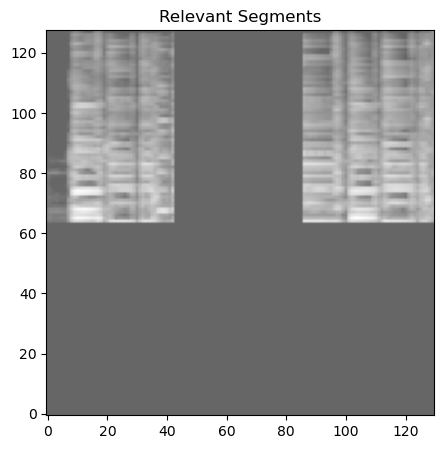

In [53]:
# - - - plot the best N segments
N = 2
#image = X_test[0]  nel codice vecchio? forse errore e doveva essere 


# make a mask for the best segments
mask = np.isin(segmentation_map, best_segments[0:N])

# make image of relevat parts
highlighted_image = np.zeros_like(image) 
highlighted_image[mask] = image[mask] 

# NEW 05 - 03 - 25 - mask for irrelevant parts
mask_irr = np.isin(segmentation_map, [best_segments[-1]])
highlighted_image_irr = np.zeros_like(image) 
highlighted_image_irr[mask_irr] = image[mask_irr] 

plt.figure(figsize=(5, 5))
plt.imshow(image[:, :, 0], aspect='auto',  origin='lower', cmap='gray', alpha=0.3)
plt.imshow(highlighted_image[:, :, 0], aspect='auto',  origin='lower', cmap='gray', alpha=0.6)
plt.title('Relevant Segments')

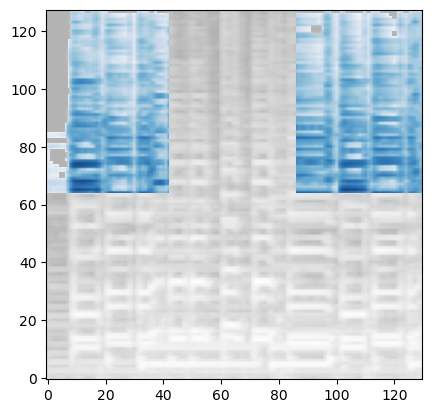

In [61]:
import numpy as np  
import matplotlib.pyplot as plt

# - - - plot the best N segments
image = instance.copy()
image_height, image_width = image.shape[:2]

# make a mask for the best segments
mask = np.isin(segmentation_map, best_segments[0:N])

# make image of relevat parts
highlighted_image = np.zeros_like(image) 
highlighted_image[mask] = image[mask] 

# Display the base image in grayscale
plt.imshow(image[:, :, 0], aspect='auto', origin='lower', cmap='gray', alpha=0.3)

# Mask for the relevant part (nonzero values in highlighted_image)
mask_rel = highlighted_image[:, :, 0] != 0
plt.imshow(np.ma.masked_where(~mask_rel, highlighted_image[:, :, 0]), aspect='auto', origin='lower', cmap='Blues', alpha=0.9) 

# Make the aspect ratio square-like
plt.gca().set_aspect('equal', adjustable='box')

# Save the image to a file (e.g., "output_image.png")
#plt.savefig(r'\spectrogram.png', bbox_inches='tight', dpi=300)

# Show the final result
plt.show()

### Accuracy song level

In [6]:
# imports and constants
import pickle
import numpy as np
import os
import gc
from pprint import pprint
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

TEST_SPEC_PATH = 'C:\\Users\\miche\\spyder_10jan2024\\folders_samples_spec_ecc\\1__app_emotions\\test_data_dict.pkl'
#TEST_SPEC_PATH = 'C:\\Users\\miche\\spyder_10jan2024\\folders_samples_spec_ecc\\1__app_emotions\\test_data_dict_50overlap.pkl'
#TEST_SPEC_PATH = 'C:\\Users\\miche\\spyder_10jan2024\\folders_samples_spec_ecc\\1__app_emotions\\test_data_dict_75overlap.pkl'
#SAVE_MODEL_PATH = r'C:\Users\miche\spyder_10jan2024\folders_samples_spec_ecc\1__app_emotions\models\for_heatmap\patience_5_validation_set\model_75_over_53.h5'

# load test set - that has the paths saved
with open(TEST_SPEC_PATH, 'rb') as f:
    data_test = pickle.load(f)

# load model
SAVE_MODEL_PATH = r'C:\Users\miche\jupyter_08jan24\7__XAI_emotion_project\keras_tuner_15epochs_trial30_exec5\best_model_1_acc_53.14.h5'
model = load_model(SAVE_MODEL_PATH)

# test:no over, model:<no over 54 %
# test:50, model:75 > 60%
# test:no over, model:75 > 64%

In [7]:
# riscritta da zero. non propriamente il mio stile perchè avrei forse usato un dictionary con 'path', 'label', 'pred', 'label', 'segm_pred'
# qui invece come risultato ottengo un dictionary che ha come key il 'path' e contine una lista con i risultati

# song_predictions['path_1'] = (2,     2,   [6, 1.2, 0.71, 1],  [ [], [], [] ,..])
# song_predictions['path_2'] = (true, pred, softmax summation, softmax for each segment)
# ...


from collections import defaultdict
import numpy as np
import os

def compute_song_level_accuracy_softmax_avg(model, data_dict, verbose=False):

    """
    Computes song-level accuracy via softmax output summation over segments.

    Args:
        model: Trained CNN model.
        data_dict: Dict with keys 'spec', 'label', 'original_path', 'segment_index'
        verbose: Print per-song prediction results if True.

    Returns:
        song_accuracy: float
        song_predictions: dict mapping song_path to (true_label, predicted_label, summed_softmax, segment_preds)
    """

    song_segments = defaultdict(list)
    song_labels = {}

    for spec, label, path, seg_idx in zip(data_dict['spec'], data_dict['label'], data_dict['original_path'], data_dict['segment_index']):

        song_segments[path].append((seg_idx, spec))   #  m. esempio: song_segments['path_1'] = [(0, segm0), (1, segm1), (2, segm2)]
        song_labels[path] = label                     #  m. esempio:  song_labels['path_1'] = 3

    correct = 0
    total = 0
    song_predictions = {}

    for song_path, seg_data in song_segments.items():

        segment_specs = [spec for _, spec in seg_data]    # m. I ignored the sorting of segments, they are already sorted
        segment_array = np.array(segment_specs)[..., np.newaxis]
        segment_array = np.repeat(segment_array, 3, axis=-1)
        
        preds = model.predict(segment_array, verbose=0)   # m. get prediciton for bacth od segments -> [[.2, .3, .5, .0], [...], [...]]
        summed_softmax = np.sum(preds, axis=0)            # sum softmax prediciton of all the segments
        pred_label = np.argmax(summed_softmax)
        true_label = song_labels[song_path]

        if verbose: print(f'song: {os.path.basename(song_path)} | True {true_label} | Pred {pred_label} | segments: {len(segment_specs)}')

        song_predictions[song_path] = (true_label, pred_label, summed_softmax, preds.tolist())  # save prediction and softmax output

        if pred_label == true_label:
            correct+=1
        total+=1

    accuracy = correct / total if total > 0 else 0.0
    print(f'Song-level Accuracy (softmax sum): {accuracy:.6f} ({correct}/{total})')
    
    return accuracy, song_predictions
    
accuracy, song_predictions = compute_song_level_accuracy_softmax_avg(model, data_test, verbose=False)

Song-level Accuracy (softmax sum): 0.535714 (45/84)


### Routine to have many evaluations for the same train overlap: e.g. 0% overlap in train

In [8]:
# this cell does the following
# 1. create the model and train with the TRAIN na TEST set previously defined:  [X_train, ...]
# 2. predict ion the test set for the 0%, 50% and 75% overlap
# 3. save results in a json file

from keras.callbacks import EarlyStopping
import tensorflow as tf
import gc
import json
import pickle

TEST_SPEC_PATH_0 = 'C:\\Users\\miche\\spyder_10jan2024\\folders_samples_spec_ecc\\1__app_emotions\\test_data_dict.pkl'
TEST_SPEC_PATH_50 = 'C:\\Users\\miche\\spyder_10jan2024\\folders_samples_spec_ecc\\1__app_emotions\\test_data_dict_50overlap.pkl'
TEST_SPEC_PATH_75 = 'C:\\Users\\miche\\spyder_10jan2024\\folders_samples_spec_ecc\\1__app_emotions\\test_data_dict_75overlap.pkl'
test_paths = [TEST_SPEC_PATH_0, TEST_SPEC_PATH_50, TEST_SPEC_PATH_75]


# dict to save the results
results_song_level = {
    'test 0%': [],
    'test 50%': [],
    'test 75%': []   
}

# constants
CLASSES = 4
BATCH_SIZE = 32
EPOCHS = 20 # before it was 30
FILTERS = [8, 8, 16, 16]
NEURONS = 32
LEARNING_RATE = 0.0001
PATIENCE = 10

REPETITIONS = 10


for i in range(REPETITIONS):

    print(f'\n--- Repetition {i+1} / {REPETITIONS} ---')
    
    # clear session and create model
    tf.keras.backend.clear_session()
    gc.collect()
    model = build_model(input_shape =  X_test.shape[1:], learning_rate=LEARNING_RATE, classes=CLASSES, filters=FILTERS, neurons=NEURONS)
        
    # early stopping and train the model
    #early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True, verbose=2)  # or try monitor='val_accuracy'
    #history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=EPOCHS, batch_size=BATCH_SIZE, shuffle=True, callbacks=[early_stopping])
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=EPOCHS, batch_size=BATCH_SIZE, shuffle=True)
    print(model.evaluate(X_test, y_test))
    
    # for each test set (0, 50, and 75), evaluate the model at song level and save the result
    for test_path, result_key in zip(test_paths, results_song_level.keys()):
    
        # load data
        with open(test_path, 'rb') as f:
            data_test = pickle.load(f)
    
        # evaluate 
        accuracy, song_predictions = compute_song_level_accuracy_softmax_avg(model, data_test, verbose=False)
        results_song_level[result_key].append(accuracy)


print(results_song_level)

OVERLAP_RESULTS_PATH = 'C:\\Users\\miche\\spyder_10jan2024\\folders_samples_spec_ecc\\1__app_emotions\\2__overlap_anlysis\\overlap_xx.json'
with open(OVERLAP_RESULTS_PATH, 'w') as f:
    json.dump(results_song_level, f, indent=3)


# fare la media fra i modelli (10)
results_mean_std = {
    'test 0%': [np.mean(results_song_level['test 0%']), np.std(results_song_level['test 0%'])],
    'test 50%': [np.mean(results_song_level['test 50%']), np.std(results_song_level['test 50%'])],
    'test 75%': [np.mean(results_song_level['test 75%']), np.std(results_song_level['test 75%'])] 
}
SUMMARY_OVERLAP_RESULTS_PATH = 'C:\\Users\\miche\\spyder_10jan2024\\folders_samples_spec_ecc\\1__app_emotions\\2__overlap_anlysis\\overlap_xx_summary.json'
with open(SUMMARY_OVERLAP_RESULTS_PATH, 'w') as f:
    json.dump(results_mean_std, f, indent=3)


--- Repetition 1 / 10 ---
Epoch 1/20
136/136 [==============================] - 9s 47ms/step - loss: 1.4300 - accuracy: 0.3679 - val_loss: 1.5357 - val_accuracy: 0.2304
Epoch 2/20
136/136 [==============================] - 4s 31ms/step - loss: 1.1550 - accuracy: 0.4631 - val_loss: 2.0335 - val_accuracy: 0.2088
Epoch 3/20
136/136 [==============================] - 6s 42ms/step - loss: 1.0703 - accuracy: 0.5084 - val_loss: 1.7323 - val_accuracy: 0.2412
Epoch 4/20
136/136 [==============================] - 6s 47ms/step - loss: 1.0207 - accuracy: 0.5329 - val_loss: 1.4968 - val_accuracy: 0.3353
Epoch 5/20
136/136 [==============================] - 5s 34ms/step - loss: 0.9800 - accuracy: 0.5503 - val_loss: 1.2114 - val_accuracy: 0.4461
Epoch 6/20
136/136 [==============================] - 6s 46ms/step - loss: 0.9431 - accuracy: 0.5908 - val_loss: 1.1940 - val_accuracy: 0.4637
Epoch 7/20
136/136 [==============================] - 5s 36ms/step - loss: 0.9061 - accuracy: 0.5970 - val_loss: 1.

In [7]:
OVERLAP_RESULTS_PATH = 'C:\\Users\\miche\\spyder_10jan2024\\folders_samples_spec_ecc\\1__app_emotions\\2__overlap_anlysis\\overlap_xx.json'
with open(OVERLAP_RESULTS_PATH, 'w') as f:
    json.dump(results_song_level, f, indent=3)


# fare la media fra i modelli (10)
results_mean_std = {
    'test 0%': [np.mean(results_song_level['test 0%']), np.std(results_song_level['test 0%'])],
    'test 50%': [np.mean(results_song_level['test 50%']), np.std(results_song_level['test 50%'])],
    'test 75%': [np.mean(results_song_level['test 75%']), np.std(results_song_level['test 75%'])] 
}
SUMMARY_OVERLAP_RESULTS_PATH = 'C:\\Users\\miche\\spyder_10jan2024\\folders_samples_spec_ecc\\1__app_emotions\\2__overlap_anlysis\\overlap_xx_summary.json'
with open(SUMMARY_OVERLAP_RESULTS_PATH, 'w') as f:
    json.dump(results_mean_std, f, indent=3)

In [73]:
# load files
SUMMARY_OVERLAP_0 = 'C:\\Users\\miche\\spyder_10jan2024\\folders_samples_spec_ecc\\1__app_emotions\\overlap_anlysis\\overlap_0_summary.json'
SUMMARY_OVERLAP_50 = 'C:\\Users\\miche\\spyder_10jan2024\\folders_samples_spec_ecc\\1__app_emotions\\overlap_anlysis\\overlap_50_summary.json'
SUMMARY_OVERLAP_75 = 'C:\\Users\\miche\\spyder_10jan2024\\folders_samples_spec_ecc\\1__app_emotions\\overlap_anlysis\\overlap_75_summary.json'

with open(SUMMARY_OVERLAP_0, 'r') as f:
    results_0 = json.load(f)
with open(SUMMARY_OVERLAP_50, 'r') as f:
    results_50 = json.load(f)
with open(SUMMARY_OVERLAP_75, 'r') as f:
    results_75 = json.load(f)


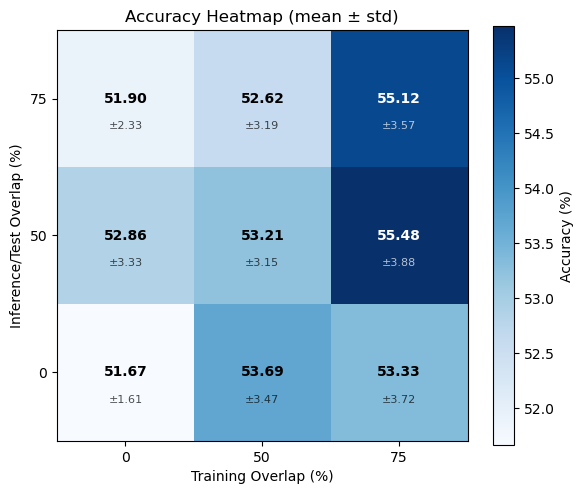

In [83]:
import matplotlib.pyplot as plt
import numpy as np

# Simulated summary results (mean and std)
results_dicts = [results_0, results_50, results_75]
train_overlaps = [0, 50, 75]
test_overlaps = [0, 50, 75]

# Prepare matrices for mean and std
means = []
stds = []

for test in test_overlaps:
    mean_row = []
    std_row = []
    for results_dict in results_dicts:
        mean_acc = results_dict[f'test {test}%'][0]  # mean accuracy
        std_acc = results_dict[f'test {test}%'][1]   # std deviation
        mean_row.append(mean_acc * 100)  # convert to %
        std_row.append(std_acc * 100)    # convert to %
    means.append(mean_row)
    stds.append(std_row)

means = np.array(means)
stds = np.array(stds)

# Plot heatmap of means
fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(means, cmap='Blues')

vmax = np.max(means)

# Annotate cells with mean ± std
for i in range(len(test_overlaps)):
    for j in range(len(train_overlaps)):
        mean_val = means[i, j]
        std_val = stds[i, j]
        color = "white" if mean_val > vmax * 0.97 else "black"

        # Mean slightly above center
        ax.text(j, i , f"{mean_val:.2f}", ha="center", va="center", color=color, fontsize=10, fontweight='bold')
        # Std slightly below center
        ax.text(j, i - 0.2, f"±{std_val:.2f}", ha="center", va="center", color=color, fontsize=8, alpha=0.7)


# Axes setup
ax.set_xticks(np.arange(len(train_overlaps)))
ax.set_yticks(np.arange(len(test_overlaps)))
ax.set_xticklabels(train_overlaps)
ax.set_yticklabels(test_overlaps)

ax.set_xlabel("Training Overlap (%)")
ax.set_ylabel("Inference/Test Overlap (%)")
ax.set_title("Accuracy Heatmap (mean ± std)")

# Colorbar
cbar = ax.figure.colorbar(im, ax=ax)
cbar.set_label("Accuracy (%)")

plt.tight_layout()
ax.invert_yaxis()

# Save the figure (optional)
SAVE = True
heat_path = r'C:\Users\miche\spyder_10jan2024\folders_samples_spec_ecc\1__app_emotions\overlap_anlysis\pat10_validation20_10runs.png'
if SAVE:
    plt.savefig(heat_path, dpi=300)

plt.show()



### histograms and conf matrix

Plot saved to: C:\Users\miche\spyder_10jan2024\folders_samples_spec_ecc\1__app_emotions\4__histograms\emotion_histograms_xx.png


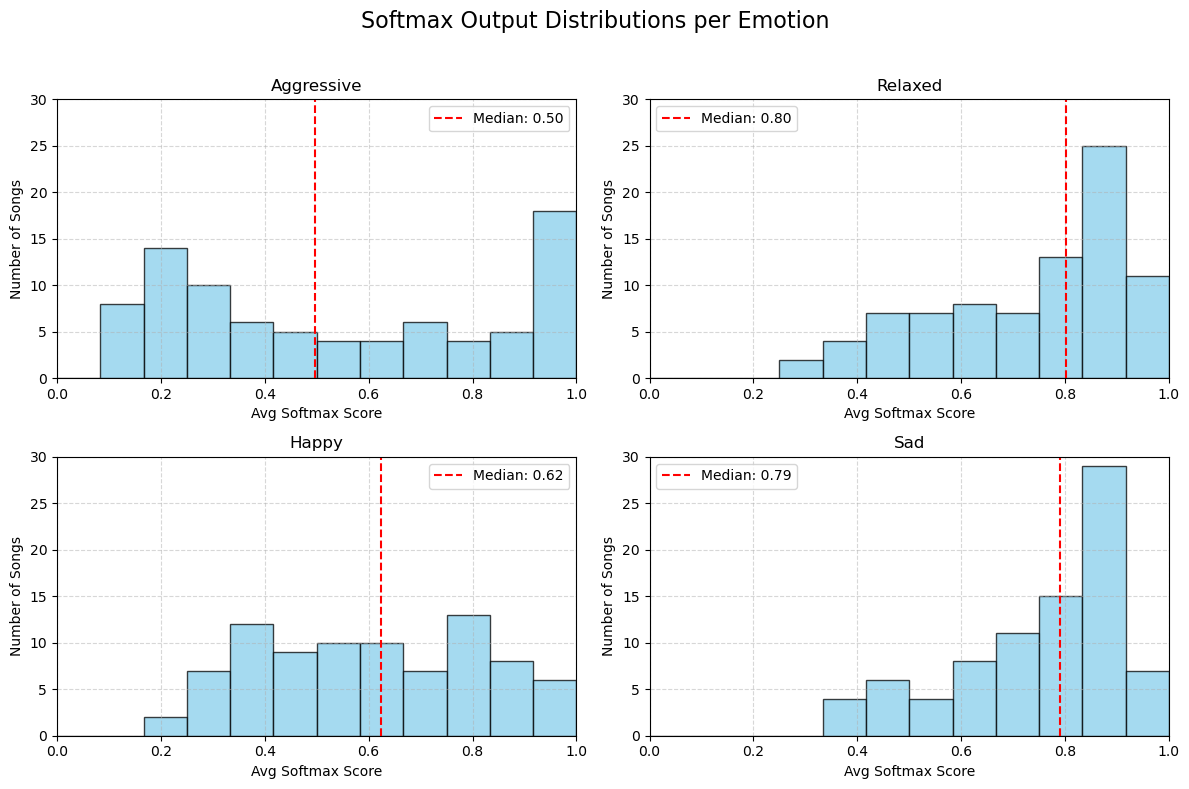

In [42]:
import matplotlib.pyplot as plt
import numpy as np

def plot_emotion_distributions_subplots(song_predictions, emotions, save_path=None, num_bins=20):
    """
    Create a 2x2 subplot of softmax score histograms per emotion, with fixed bin width and range,
    and consistent y-axis limits across all subplots.
    """
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    axes = axes.flatten()

    bin_edges = np.linspace(0, 1, num_bins + 1)  # consistent bins for all plots

    # Step 1: Collect outputs for all emotions
    all_outputs = []
    for i, _ in enumerate(emotions):
        outputs = []
        for _, (_, _, summed_softmax, segment_preds) in song_predictions.items():
            avg_softmax = np.array(summed_softmax) / len(segment_preds)
            outputs.append(avg_softmax[i])
        all_outputs.append(outputs)

    # Step 2: Compute max y-value across all histograms for consistent ylim
    max_count = 0
    for outputs in all_outputs:
        counts, _ = np.histogram(outputs, bins=bin_edges)
        max_count = max(max_count, counts.max() if len(counts) > 0 else 0)

    # Step 3: Plot with consistent ylim
    for i, emotion in enumerate(emotions):
        outputs = all_outputs[i]
        median_val = np.median(outputs) if outputs else 0

        ax = axes[i]
        ax.hist(outputs, bins=bin_edges, alpha=0.75, color='skyblue', edgecolor='black')
        ax.axvline(median_val, color='red', linestyle='--', label=f'Median: {median_val:.2f}')
        ax.set_title(f'{emotion.capitalize()}')
        ax.set_xlabel('Avg Softmax Score')
        ax.set_ylabel('Number of Songs')
        ax.set_xlim(0, 1)
        ax.set_ylim(0, max_count + 1)  # consistent y-limit with padding
        ax.grid(True, linestyle='--', alpha=0.5)
        ax.legend()

    plt.suptitle('Softmax Output Distributions per Emotion', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Plot saved to: {save_path}")

    plt.show()


# Usage
EMOTIONS = ['aggressive', 'relaxed', 'happy', 'sad']
save_path = r'C:\Users\miche\spyder_10jan2024\folders_samples_spec_ecc\1__app_emotions\4__histograms\emotion_histograms_xx.png'
plot_emotion_distributions_subplots(song_predictions, EMOTIONS, save_path=save_path, num_bins=12)



Plot saved to: C:\Users\miche\spyder_10jan2024\folders_samples_spec_ecc\1__app_emotions\4__histograms\emotion_histograms_exclude_main_emotion_train_sigmoid.png


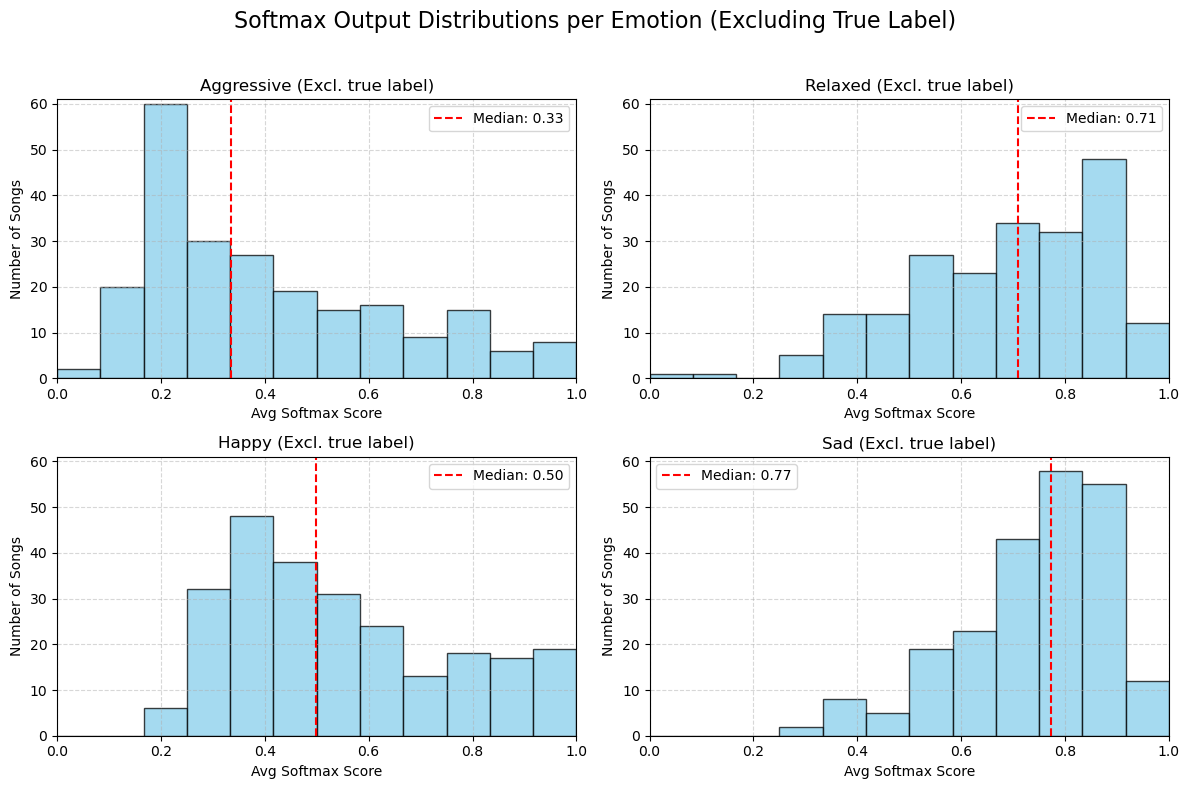

In [38]:
import matplotlib.pyplot as plt
import numpy as np

def plot_emotion_distributions_subplots_exclude_true(song_predictions, emotions, save_path=None, num_bins=12):
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    axes = axes.flatten()

    bin_edges = np.linspace(0, 1, num_bins + 1)

    # Step 1: Collect all outputs per emotion excluding true label
    all_outputs = []
    for i, _ in enumerate(emotions):
        outputs = []
        for _, (true_label, _, summed_softmax, segment_preds) in song_predictions.items():
            if true_label != i:
                avg_softmax = np.array(summed_softmax) / len(segment_preds)
                outputs.append(avg_softmax[i])
        all_outputs.append(outputs)

    # Step 2: Find max y-value from histograms for consistent ylim
    max_count = 0
    for outputs in all_outputs:
        counts, _ = np.histogram(outputs, bins=bin_edges)
        max_count = max(max_count, counts.max() if len(counts) > 0 else 0)

    # Step 3: Plot with consistent ylim
    for i, emotion in enumerate(emotions):
        outputs = all_outputs[i]
        median_val = np.median(outputs) if outputs else 0

        ax = axes[i]
        ax.hist(outputs, bins=bin_edges, alpha=0.75, color='skyblue', edgecolor='black')
        ax.axvline(median_val, color='red', linestyle='--', label=f'Median: {median_val:.2f}')
        ax.set_title(f'{emotion.capitalize()} (Excl. true label)')
        ax.set_xlabel('Avg Softmax Score')
        ax.set_ylabel('Number of Songs')
        ax.set_xlim(0, 1)
        ax.set_ylim(0, max_count + 1)  # consistent y-limit with a little padding
        ax.grid(True, linestyle='--', alpha=0.5)
        ax.legend()

    plt.suptitle('Softmax Output Distributions per Emotion (Excluding True Label)', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Plot saved to: {save_path}")

    plt.show()

# Usage example:
EMOTIONS = ['aggressive', 'relaxed', 'happy', 'sad']
save_path = r'C:\Users\miche\spyder_10jan2024\folders_samples_spec_ecc\1__app_emotions\4__histograms\emotion_histograms_exclude_main_emotion_train_sigmoid.png'

plot_emotion_distributions_subplots_exclude_true(song_predictions, EMOTIONS, save_path=save_path)


Plot saved to: C:\Users\miche\spyder_10jan2024\folders_samples_spec_ecc\1__app_emotions\4__histograms\only songs_with_true_emotion_sigmoid.png


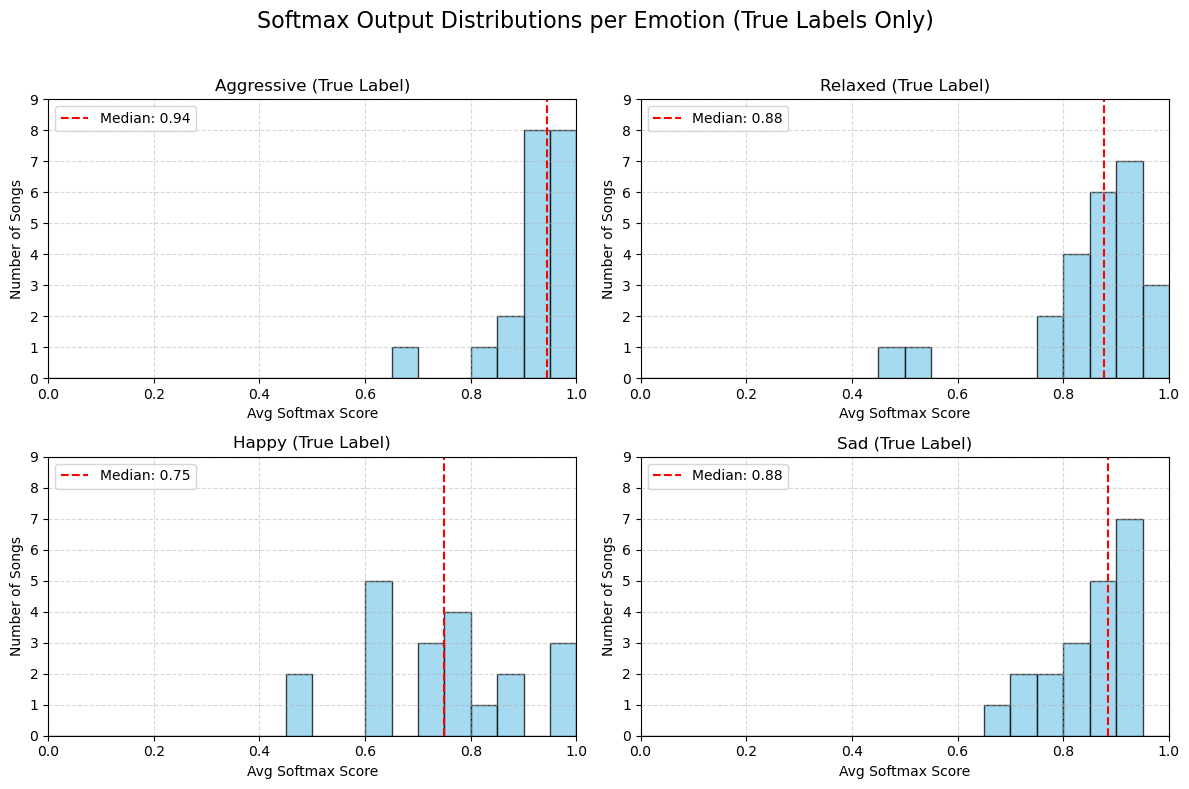

In [46]:
# check-rewrite code
def plot_emotion_distributions_subplots(song_predictions, emotions, save_path=None, num_bins=20):
    """
    Create a 2x2 subplot of softmax score histograms per emotion, using only songs with that true label.
    """
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    axes = axes.flatten()

    bin_edges = np.linspace(0, 1, num_bins + 1)

    # Step 1: Collect outputs for all emotions based on true labels
    all_outputs = []
    for i, _ in enumerate(emotions):
        outputs = []
        for _, (true_label_index, _, summed_softmax, segment_preds) in song_predictions.items():
            if true_label_index == i:
                avg_softmax = np.array(summed_softmax) / len(segment_preds)
                outputs.append(avg_softmax[i])
        all_outputs.append(outputs)

    # Step 2: Compute max y-value across all histograms for consistent ylim
    max_count = 0
    for outputs in all_outputs:
        counts, _ = np.histogram(outputs, bins=bin_edges)
        max_count = max(max_count, counts.max() if len(counts) > 0 else 0)

    # Step 3: Plot
    for i, emotion in enumerate(emotions):
        outputs = all_outputs[i]
        median_val = np.median(outputs) if outputs else 0

        ax = axes[i]
        ax.hist(outputs, bins=bin_edges, alpha=0.75, color='skyblue', edgecolor='black')
        ax.axvline(median_val, color='red', linestyle='--', label=f'Median: {median_val:.2f}')
        ax.set_title(f'{emotion.capitalize()} (True Label)')
        ax.set_xlabel('Avg Softmax Score')
        ax.set_ylabel('Number of Songs')
        ax.set_xlim(0, 1)
        ax.set_ylim(0, max_count + 1)
        ax.grid(True, linestyle='--', alpha=0.5)
        ax.legend()

    plt.suptitle('Softmax Output Distributions per Emotion (True Labels Only)', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Plot saved to: {save_path}")

    plt.show()

save_path = r'C:\Users\miche\spyder_10jan2024\folders_samples_spec_ecc\1__app_emotions\4__histograms\only songs_with_true_emotion_sigmoid.png'

plot_emotion_distributions_subplots(song_predictions, EMOTIONS, save_path=save_path, num_bins=20)

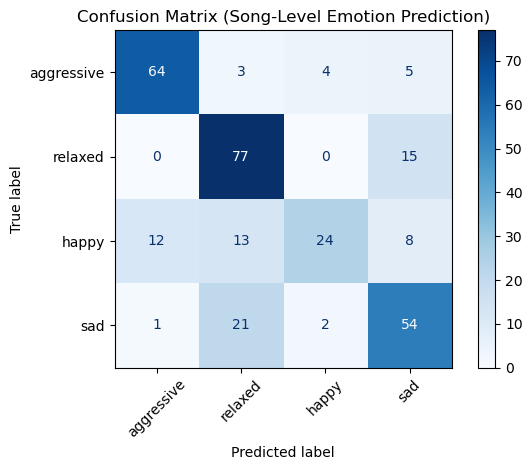

In [39]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
SAVE=True

EMOTIONS = ['aggressive', 'relaxed', 'happy', 'sad']

y_true = [v[0] for v in song_predictions.values()]  # labels
y_pred = [v[1] for v in song_predictions.values()]  # predictions

cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=EMOTIONS)
# Display it with labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=EMOTIONS)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix (Song-Level Emotion Prediction)')
plt.xticks(rotation=45)
plt.tight_layout()

if SAVE:
    save_path = r'C:\Users\miche\spyder_10jan2024\folders_samples_spec_ecc\1__app_emotions\4__histograms\confusion_matrix_train_sigmoid.png'
    plt.savefig(save_path, dpi=300, bbox_inches='tight')

plt.show()

In [38]:
def print_simple_song_preds(song_predictions, confidence_rule='segment_average'):
    '''
    Print each song's true label, predicted label, whether the prediction was correct,
    and a confidence score based on the specified confidence_rule:
    
    - 'simple_normalization': (top1 - top2) / top1
    - 'segment_average': top1 - top2 of average softmax over segments
    '''
    for path, (true_label, pred_label, summed_softmax, segment_preds) in song_predictions.items():
        song_name = os.path.basename(path)
        status = '✅' if true_label == pred_label else '❌'

        # Compute the confidence score based on the selected rule
        softmax_array = np.array(summed_softmax)
        
        if confidence_rule == 'simple_normalization':
            best_two = np.sort(softmax_array)[-2:]
            top1, top2 = best_two[1], best_two[0]
            confidence_score = (top1 - top2) / top1 if top1 > 0 else 0

        elif confidence_rule == 'segment_average':
            num_segments = len(segment_preds)
            avg_softmax = softmax_array / num_segments
            best_two = np.sort(avg_softmax)[-2:]
            top1, top2 = best_two[1], best_two[0]
            confidence_score = top1 - top2

        else:
            raise ValueError(f"Unsupported confidence_rule: {confidence_rule}")
        
        print(f'{song_name:65} | True: {true_label:<5} Pred: {pred_label:<5} {status} | Confidence: {confidence_score:.2f}')


print_simple_song_preds(song_predictions, confidence_rule='simple_normalization')


13_aggressive_i1_steelstring-guitar_DavBen_pick_20200623.wav      | True: 0     Pred: 0     ✅ | Confidence: 0.80
14_aggressive_i2_steelstring-guitar_DavBen_pick_20200623.wav      | True: 0     Pred: 0     ✅ | Confidence: 0.82
15_aggressive_i3_steelstring-guitar_DavBen_pick_20200623.wav      | True: 0     Pred: 0     ✅ | Confidence: 0.89
212_aggressive_i1_classical-guitar_SalOli_fingers_20200714.wav    | True: 3     Pred: 0     ❌ | Confidence: 0.22
213_aggressive_i2_classical-guitar_SalOli_pick_20200714.wav       | True: 0     Pred: 0     ✅ | Confidence: 0.70
214_aggressive_i3_classical-guitar_SalOli_pick_20200714.wav       | True: 0     Pred: 0     ✅ | Confidence: 0.41
25_aggressive_i1_classical-guitar_DavBen_fingers_20200526.wav     | True: 0     Pred: 0     ✅ | Confidence: 0.34
26_aggressive_i2_classical-guitar_DavBen_pick_20200526.wav        | True: 0     Pred: 0     ✅ | Confidence: 0.85
27_aggressive_i3_classical-guitar_DavBen_pick_20200526.wav        | True: 0     Pred: 0     ✅ | 